In [1]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

from MATSgp.hapi import cpf3, cef, hum1_wei, pcqsdhc
from MATSgp import tf_pcqsdhc
from MATSgp.lineshape_meanfuncs import lineshape_from_dataframe

import matplotlib.pyplot as plt

HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [2]:
dat_files = glob.glob('../Examples/A-Band - Experimental Spectra/*forfit.csv')
dat_files.sort()
dat_files

['../Examples/A-Band - Experimental Spectra/190510_2per_43_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190510_2per_55_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190513_2per_82_forfit.csv',
 '../Examples/A-Band - Experimental Spectra/190514_2per_126_forfit.csv']

In [3]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1) for f in dat_files]

In [4]:
x = [d[:, [3, 10, 11]] for d in dat]
for d in x:
    d[:, 0] *= (10**6) / 29979245800
    d[:, 1] = np.average(d[:, 1]) + 273.15
    d[:, 2] = np.average(d[:, 2]) / 760.0
    
x = [np.hstack([x[i], np.ones((x[i].shape[0], 1))*i]) for i in range(len(x))]

dat_y = [d[:, 9] for d in dat]

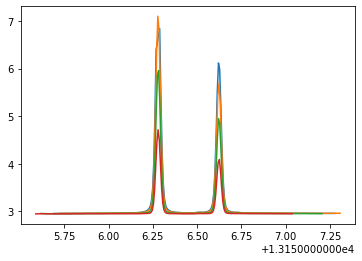

In [5]:
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.plot(x[i][:, 0], dat_y[i])
plt.show()

In [6]:
noise_scale = 10.0*np.average([np.std(dat_y[i][:10]) for i in range(len(dat_y))])
print(noise_scale)

lineparam_list = pd.read_csv('Parameter_LineList.csv', index_col=0)
for i, line in lineparam_list.iterrows():
    if i == 10:
        lineshape = lineshape_from_dataframe(line,
                                             limit_factor_dict={'SD_gamma_air':('factor', 2.0),
                                                                'nu':('magnitude', 0.1),
                                                                'sw':('factor', 2.0)},
                                             line_kwargs={'cutoff':25,
                                                          'noise_scale_factor':noise_scale,
                                                          'mole_fraction':0.01949,
                                                          'fittable':(line['sw'] >= 1.0)}
                                            )

0.008708101055790094


2021-07-08 18:25:27.893339: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-08 18:25:27.952928: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [43]:
wave = x[3][:, 0]
T = x[3][:, 1]
P = x[3][:, 2]
dInds = np.array(x[3][:, 3], dtype=np.int32)

In [44]:
mol_dens = (P / 9.869233e-7) / (1.380648813e-16 * T)

In [45]:
nu, sw, gamma0, delta0, sd_gamma, sd_delta, nuVC, eta, y = lineshape.get_dset_params(dInds,
                                                                                     ["nu", "sw", "gamma0", "delta0",
                                                                                      "sd_gamma", "sd_delta", "nuvc",
                                                                                      "eta", "y"])

In [46]:
line_intensity = lineshape.environmentdependency_intensity(T, nu, sw)

In [47]:
params = lineshape.get_params_at_TP(T, P, nu, gamma0, delta0, sd_gamma, sd_delta, nuVC, eta)

In [48]:
ref = pcqsdhc(nu[0].numpy(), *[p[0].numpy() for p in params], wave)

In [49]:
vals = tf_pcqsdhc.tf_pcqsdhc(nu, *params, wave)

In [50]:
out_ref = mol_dens * lineshape.mole_frac * line_intensity * ref[0] * 1e06
out = mol_dens * lineshape.mole_frac * line_intensity * vals[0] * 1e06

<IPython.core.display.Javascript object>


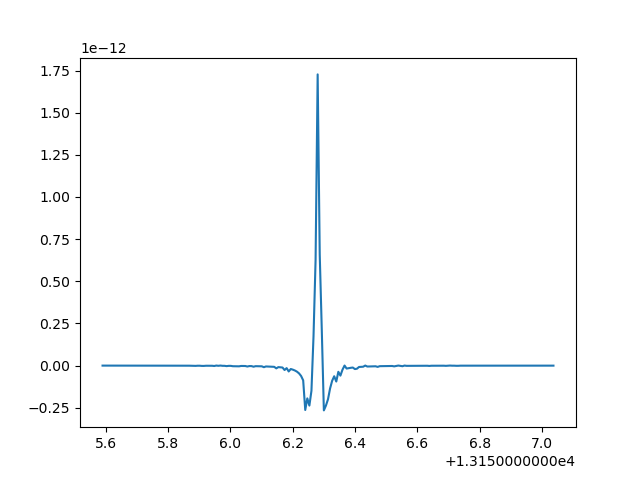

In [51]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(wave, out - out_ref)

plt.show()

In [16]:
test_real = np.random.normal(size=(10)) / 100.0
test_imag = np.random.random(size=(10)) / 100.0

tf_pcqsdhc.cpf3(test_real, test_imag) - tf.complex(*cpf3(test_real, test_imag))

<tf.Tensor: shape=(10,), dtype=complex128, numpy=
array([ 1.56927543e+57+3.06008710e+58j,  0.00000000e+00+0.00000000e+00j,
        3.22518893e+65+2.50116693e+65j, -1.08603301e+65+5.59471549e+64j,
        2.10624583e+65+5.26561458e+65j, -7.41398533e+67+4.12824183e+67j,
       -5.49246402e+57+2.86392767e+58j, -2.05358969e+66+5.79217604e+65j,
        1.83899465e+56+5.51698395e+55j, -1.33074557e+60-1.12987831e+60j])>

In [17]:
tf_pcqsdhc.cpf3(test_real, test_imag)

<tf.Tensor: shape=(10,), dtype=complex128, numpy=
array([-4.61995232e+71-3.47436177e+72j, -9.25628423e+64-9.99959349e+63j,
       -4.43151262e+79+1.03432454e+79j, -9.48912420e+78+9.88654646e+78j,
        2.67675825e+80+4.95575259e+79j,  5.94309286e+81-5.53334951e+81j,
        1.29673315e+72+3.40520680e+72j, -2.75059010e+80+1.81877910e+80j,
        2.78229592e+70+2.22735210e+70j,  1.75139441e+74+1.61735762e+74j])>

In [18]:
tf.complex(*cpf3(test_real, test_imag))

<tf.Tensor: shape=(10,), dtype=complex128, numpy=
array([-4.61995232e+71-3.47436177e+72j, -9.25628423e+64-9.99959349e+63j,
       -4.43151262e+79+1.03432454e+79j, -9.48912420e+78+9.88654646e+78j,
        2.67675825e+80+4.95575259e+79j,  5.94309286e+81-5.53334951e+81j,
        1.29673315e+72+3.40520680e+72j, -2.75059010e+80+1.81877910e+80j,
        2.78229592e+70+2.22735210e+70j,  1.75139441e+74+1.61735762e+74j])>

In [19]:
tf_pcqsdhc.cef(test_real, test_imag, 24) - cef(test_real, test_imag, 24)

<tf.Tensor: shape=(10,), dtype=complex128, numpy=
array([ 1.11022302e-16-1.73472348e-18j, -2.22044605e-16-3.46944695e-18j,
        1.11022302e-16-1.73472348e-18j,  9.99200722e-16+5.20417043e-18j,
        8.88178420e-16+2.60208521e-18j, -2.22044605e-16-1.08420217e-18j,
        8.88178420e-16-1.38777878e-17j, -1.11022302e-16-1.30104261e-18j,
       -1.11022302e-16+0.00000000e+00j, -3.33066907e-16-6.93889390e-18j])>

In [20]:
tf_pcqsdhc.cef(test_real, test_imag, 24)

<tf.Tensor: shape=(10,), dtype=complex128, numpy=
array([0.99156237-0.00798749j, 0.9966469 +0.02020414j,
       0.99528395-0.00499572j, 0.99402848+0.00390356j,
       0.99382816+0.00196597j, 0.99441583+0.00159716j,
       0.99884947-0.01161455j, 0.99403187+0.00241572j,
       0.99420194+0.01219242j, 0.99392409+0.00814181j])>

In [21]:
cef(test_real, test_imag, 24)

array([0.99156237-0.00798749j, 0.9966469 +0.02020414j,
       0.99528395-0.00499572j, 0.99402848+0.00390356j,
       0.99382816+0.00196597j, 0.99441583+0.00159716j,
       0.99884947-0.01161455j, 0.99403187+0.00241572j,
       0.99420194+0.01219242j, 0.99392409+0.00814181j])

In [22]:
tf_pcqsdhc.hum1_wei(test_real, test_imag) - tf.complex(*hum1_wei(test_real, test_imag))

<tf.Tensor: shape=(10,), dtype=complex128, numpy=
array([ 1.11022302e-16-1.73472348e-18j, -2.22044605e-16-3.46944695e-18j,
        1.11022302e-16-1.73472348e-18j,  9.99200722e-16+5.20417043e-18j,
        8.88178420e-16+2.60208521e-18j, -2.22044605e-16-1.08420217e-18j,
        8.88178420e-16-1.38777878e-17j, -1.11022302e-16-1.30104261e-18j,
       -1.11022302e-16+0.00000000e+00j, -3.33066907e-16-6.93889390e-18j])>

In [23]:
tf_pcqsdhc.hum1_wei(test_real, test_imag)

<tf.Tensor: shape=(10,), dtype=complex128, numpy=
array([0.99156237-0.00798749j, 0.9966469 +0.02020414j,
       0.99528395-0.00499572j, 0.99402848+0.00390356j,
       0.99382816+0.00196597j, 0.99441583+0.00159716j,
       0.99884947-0.01161455j, 0.99403187+0.00241572j,
       0.99420194+0.01219242j, 0.99392409+0.00814181j])>

In [24]:
tf.complex(*hum1_wei(test_real, test_imag))

<tf.Tensor: shape=(10,), dtype=complex128, numpy=
array([0.99156237-0.00798749j, 0.9966469 +0.02020414j,
       0.99528395-0.00499572j, 0.99402848+0.00390356j,
       0.99382816+0.00196597j, 0.99441583+0.00159716j,
       0.99884947-0.01161455j, 0.99403187+0.00241572j,
       0.99420194+0.01219242j, 0.99392409+0.00814181j])>